## Stock Prediction using Linear Regression, XGBoost & LSTM

In this notebook, we will only consider the effect of previous many days of close prices as a input. As the best feature is the previous day prices, we will lag the data and try to tune the lookback days for improving the predictions. 

We will implement 4 machine learning models 
1. Linear regression
2. Random Forest
3. XGBoost
4. LSTM


### Object Oriented Pipeline

We have created an Object Oriented based pipeline to Train Multiple stocks with multiple Estimators. Step by Step sequence output of this pipeline is also there in other notebooks. If someone wants to just learn what the pipeline is doing at each step. 

We have created a similar pipeline to Get stocks data and create Extensive feature extraction (around 60 features), it will fetch data for a given stock and get historical data and prepare features using various Technical Indicators and lagging effect. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from typing import TypeVar, Callable, Sequence
from functools import reduce
T = TypeVar('T')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics

from keras.models import Sequential # type: ignore
from keras.layers import Dense, Dropout, LSTM, GRU # type: ignore
from keras.optimizers import Adam, SGD # type: ignore
from keras.callbacks import ReduceLROnPlateau  # type: ignore

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

os.chdir(r'C:\Users\ashok\Desktop\SPPO\Streamlit Web App\Stock Data')


In [4]:
class Stock_Prediction_Modeling():
    def __init__(self, Stocks, models):
        self.Stocks = Stocks
        self.train_Models = models
        self.metrics = {}
        
        
    def get_stock_data(self, Ticker):
        
        file = self.Ticker + '.csv'
        Stock = pd.read_csv(file,  index_col=0)
        print('Loading Historical Price data for ' + self.Ticker + '....')
        #best features
        features_selected = ['Open','High', 'Low','Close(t)', 'QQQ_Close', 'SnP_Close', 'DJIA_Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band']

        self.df_Stock = Stock[features_selected]
        self.df_Stock = self.df_Stock.rename(columns={'Close(t)':'Close'})
        
        self.df_Stock = self.df_Stock.copy()
        self.df_Stock['Diff'] = self.df_Stock['Close'] - self.df_Stock['Open']
        self.df_Stock['High-low'] = self.df_Stock['High'] - self.df_Stock['Low']

        features_selected = ['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close','DJIA_Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band']
        self.df_Stock = self.df_Stock[features_selected]
        self.df_Stock = self.df_Stock[1000:-70]
        
        print(self.df_Stock.columns)


    def prepare_lagged_features(self, lag_stock, lag_index, lag_diff):

        print('Preparing Lagged Features for Stock, Index Funds.....')
        lags = range(1, lag_stock+1)
        lag_cols= ['Close']
        self.df_Stock=self.df_Stock.assign(**{
            '{}(t-{})'.format(col, l): self.df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

       
        lags = range(1, lag_index+1)
        lag_cols= ['QQQ_Close','SnP_Close','DJIA_Close']
        self.df_Stock= self.df_Stock.assign(**{
            '{}(t-{})'.format(col, l): self.df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        self.df_Stock = self.df_Stock.drop(columns=lag_cols)


        lags = range(1, lag_diff+1)
        lag_cols= ['Diff','High-low']
        self.df_Stock= self.df_Stock.assign(**{
            '{}(t-{})'.format(col, l): self.df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        self.df_Stock = self.df_Stock.drop(columns=lag_cols)

        remove_lags_na = max(lag_stock, lag_index, lag_diff) + 1
        print('Removing NAN rows - ', str(remove_lags_na))
        self.df_Stock = self.df_Stock.iloc[remove_lags_na:,]
        return self.df_Stock

    def get_lagged_features(self, Ticker):
        
        self.df_Stock_lagged = self.prepare_lagged_features(lag_stock = 25, lag_index = 10, lag_diff = 5)

        print(self.df_Stock_lagged.columns)
        
        self.df_Stock = self.df_Stock_lagged
        print(self.df_Stock.shape)
        print('Extracted Feature Columns after lagged effect - ')
        print(self.df_Stock.columns)
        
        '''
        self.df_Stock['Close'].plot(figsize=(10, 7))
        plt.title("Stock Price", fontsize=17)
        plt.ylabel('Price', fontsize=14)
        plt.xlabel('Time', fontsize=14)
        plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
        plt.show()
        print(self.df_Stock)
        '''




    def create_train_test_set(self):

        #self.df_Stock = self.df_Stock[:-60]
        self.features = self.df_Stock.drop(columns=['Close'], axis=1)
        self.target = self.df_Stock['Close']


        data_len = self.df_Stock.shape[0]
        print('Historical Stock Data length is - ', str(data_len))

        #create a chronological split for train and testing
        train_split = int(data_len * 0.88)
        print('Training Set length - ', str(train_split))

        val_split = train_split + int(data_len * 0.1)
        print('Validation Set length - ', str(int(data_len * 0.1)))

        print('Test Set length - ', str(int(data_len * 0.02)))

        # Splitting features and target into train, validation and test samples 
        X_train, X_val, X_test = self.features[:train_split], self.features[train_split:val_split], self.features[val_split:]
        Y_train, Y_val, Y_test = self.target[:train_split], self.target[train_split:val_split], self.target[val_split:]

        #print shape of samples
        print(X_train.shape, X_val.shape, X_test.shape)
        print(Y_train.shape, Y_val.shape, Y_test.shape)

        return X_train, X_val, X_test, Y_train, Y_val, Y_test

    def get_train_test(self):
        print('Splitting the data into Train and Test ...')
        print(' ')
        if self.ML_Model == 'LSTM':
            self.scale_LSTM_features()
            self.X_train, self.X_test, self.Y_train, self.Y_test = self.create_train_test_LSTM()
        else:
            self.X_train, self.X_val, self.X_test, self.Y_train, self.Y_val, self.Y_test = self.create_train_test_set()

    def get_mape(self, y_true, y_pred): 
        """
        Compute mean absolute percentage error (MAPE)
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    
    def calc_metrics(self):
        print('Evaluating Metrics - MAE, MAPE, RMSE, R Square')
        print(' ')
        if self.ML_Model == 'LSTM':
        
            self.Train_RSq = round(metrics.r2_score(self.Y_train,self.Y_train_pred),2)
            self.Train_EV = round(metrics.explained_variance_score(self.Y_train,self.Y_train_pred),2)
            self.Train_MAPE = round(self.get_mape(self.Y_train,self.Y_train_pred), 2)
            self.Train_MSE = round(metrics.mean_squared_error(self.Y_train,self.Y_train_pred), 2) 
            self.Train_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_train,self.Y_train_pred)),2)
            self.Train_MAE = round(metrics.mean_absolute_error(self.Y_train,self.Y_train_pred),2)

            
            self.Test_RSq = round(metrics.r2_score(self.Y_test,self.Y_test_pred),2)
            self.Test_EV = round(metrics.explained_variance_score(self.Y_test,self.Y_test_pred),2)
            self.Test_MAPE = round(self.get_mape(self.Y_test,self.Y_test_pred), 2)
            self.Test_MSE = round(metrics.mean_squared_error(self.Y_test,self.Y_test_pred), 2) 
            self.Test_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_test,self.Y_test_pred)),2)
            self.Test_MAE = round(metrics.mean_absolute_error(self.Y_test,self.Y_test_pred),2)
        else:
            
            self.Train_RSq = round(metrics.r2_score(self.Y_train,self.Y_train_pred),2)
            self.Train_EV = round(metrics.explained_variance_score(self.Y_train,self.Y_train_pred),2)
            self.Train_MAPE = round(self.get_mape(self.Y_train,self.Y_train_pred), 2)
            self.Train_MSE = round(metrics.mean_squared_error(self.Y_train,self.Y_train_pred), 2) 
            self.Train_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_train,self.Y_train_pred)),2)
            self.Train_MAE = round(metrics.mean_absolute_error(self.Y_train,self.Y_train_pred),2)

            self.Val_RSq = round(metrics.r2_score(self.Y_val,self.Y_val_pred),2)
            self.Val_EV = round(metrics.explained_variance_score(self.Y_val,self.Y_val_pred),2)
            self.Val_MAPE = round(self.get_mape(self.Y_val,self.Y_val_pred), 2)
            self.Val_MSE = round(metrics.mean_squared_error(self.Y_train,self.Y_train_pred), 2) 
            self.Val_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_val,self.Y_val_pred)),2)
            self.Val_MAE = round(metrics.mean_absolute_error(self.Y_val,self.Y_val_pred),2)

            self.Test_RSq = round(metrics.r2_score(self.Y_test,self.Y_test_pred),2)
            self.Test_EV = round(metrics.explained_variance_score(self.Y_test,self.Y_test_pred),2)
            self.Test_MAPE = round(self.get_mape(self.Y_test,self.Y_test_pred), 2)
            self.Test_MSE = round(metrics.mean_squared_error(self.Y_test,self.Y_test_pred), 2) 
            self.Test_RMSE = round(np.sqrt(metrics.mean_squared_error(self.Y_test,self.Y_test_pred)),2)
            self.Test_MAE = round(metrics.mean_absolute_error(self.Y_test,self.Y_test_pred),2)


    def update_metrics_tracker(self):
        print('Updating the metrics tracker....')
        if self.ML_Model == 'LSTM':
            #self.metrics[self.Ticker] = {}
            self.metrics[self.Ticker][self.ML_Model] = {'Train_MAE': self.Train_MAE, 'Train_RSq': self.Train_RSq, 'Train_MAPE': self.Train_MAPE , 'Train_RMSE': self.Train_RMSE,
                          'Test_MAE': self.Test_MAE, 'Test_RSq': self.Test_RSq, 'Test_MAPE': self.Test_MAPE, 'Test_RMSE': self.Test_RMSE}
        else:
            ##self.metrics[self.Ticker] = {{}}
            self.metrics[self.Ticker][self.ML_Model] = {'Train_MAE': self.Train_MAE, 'Train_RSq': self.Train_RSq, 'Train_MAPE': self.Train_MAPE , 'Train_RMSE': self.Train_RMSE,
                          'Test_MAE': self.Val_MAE, 'Test_RSq': self.Val_RSq, 'Test_MAPE': self.Val_MAPE, 'Test_RMSE': self.Val_RMSE}

       

    def train_model(self, Ticker):

        for model in self.train_Models:
            self.ML_Model = model
            if self.ML_Model == 'Linear Regression':
                
                print(' ')
                print('Training Linear Regressiom Model')
                
                self.get_train_test()
                
                plt.plot(self.Y_train)
                plt.plot(self.Y_val)
                plt.plot(self.Y_test)
                plt.legend(['Train', 'Val', 'Test'])
                plt.title('Stock Price Time Series')
                plt.show()
                

                
                from sklearn.linear_model import LinearRegression
                lr = LinearRegression()
                lr.fit(self.X_train, self.Y_train)
                print('LR Coefficients: \n', lr.coef_)
                print('LR Intercept: \n', lr.intercept_)

                print("Performance (R^2): ", lr.score(self.X_train, self.Y_train))

                self.Y_train_pred = lr.predict(self.X_train)
                self.Y_val_pred = lr.predict(self.X_val)
                self.Y_test_pred = lr.predict(self.X_test)

                self.calc_metrics()
                self.update_metrics_tracker()
                self.plot_prediction()
                
            elif self.ML_Model == 'XGBoost':
                print(' ')
                print('Training XGBoost Model')
                
                self.get_train_test()
                
                from xgboost import XGBRegressor
                n_estimators = 100             # Number of boosted trees to fit. default = 100
                max_depth = 10                 # Maximum tree depth for base learners. default = 3
                learning_rate = 0.2            # Boosting learning rate (xgb’s “eta”). default = 0.1
                min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
                subsample = 1                  # Subsample ratio of the training instance. default = 1
                colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
                colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
                gamma = 2                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

                model_seed = 42



                xgb = XGBRegressor(seed=model_seed,
                                         n_estimators=n_estimators,
                                         max_depth=max_depth,
                                         learning_rate=learning_rate,
                                         min_child_weight=min_child_weight,
                                         subsample=subsample,
                                         colsample_bytree=colsample_bytree,
                                         colsample_bylevel=colsample_bylevel,
                                         gamma=gamma)
                xgb.fit(self.X_train, self.Y_train)

                self.Y_train_pred = xgb.predict(self.X_train)
                self.Y_val_pred = xgb.predict(self.X_val)
                self.Y_test_pred = xgb.predict(self.X_test)

                self.calc_metrics()
                self.update_metrics_tracker()
                
                fig = plt.figure(figsize=(8,8))
                plt.xticks(rotation='vertical')
                plt.bar([i for i in range(len(xgb.feature_importances_))], xgb.feature_importances_.tolist(), tick_label=self.X_test.columns)
                plt.title('Feature importance of the technical indicators.')
                plt.show()
                
                self.plot_prediction()
                
            elif self.ML_Model == 'Random Forest':
                print(' ')
                print('Training Random Forest Model')
                
                self.get_train_test()
                rf = RandomForestRegressor(n_estimators=100, max_depth=50, random_state=42)
                rf.fit(self.X_train, self.Y_train)

                self.Y_train_pred = rf.predict(self.X_train)
                self.Y_val_pred = rf.predict(self.X_val)
                self.Y_test_pred = rf.predict(self.X_test)
                
                self.calc_metrics()
                self.update_metrics_tracker()
                self.plot_prediction()
                
            
            elif self.ML_Model == 'LSTM':
                print(' ')
                print('Training LSTM Model')
                
                self.get_train_test()
                #self.X_train, self.X_test, self.Y_train, self.Y_test = create_train_test_LSTM()
                
                self.X_train = np.reshape(self.X_train, (self.X_train.shape[0],self.X_train.shape[1],1))
                self.X_test = np.reshape(self.X_test, (self.X_test.shape[0],self.X_test.shape[1],1))
                print(self.X_train.shape, self.Y_train.shape, self.X_test.shape, self.Y_test.shape)

                
                self.history_lstm = self.get_lstm_model()
                #self.history_lstm = self.lstm.fit(X_train, Y_train, batch_size=16, epochs=30, validation_data=(self.X_test, self.Y_test), shuffle=False, callbacks=[rlrop])

                plt.plot(self.history_lstm.history['mean_absolute_error'], label='train')
                plt.plot(self.history_lstm.history['val_mean_absolute_error'], label='test')
                plt.title('Mean Abs Error LSTM')
                plt.legend()
                plt.show()

                plt.plot(self.history_lstm.history['loss'], label='train')
                plt.plot(self.history_lstm.history['val_loss'], label='test')
                plt.title('Loss LSTM')
                plt.legend()
                plt.show()

                mae = self.lstm.evaluate(self.X_test, self.Y_test, batch_size=16)
                print('Mean Absolute Error for Y:', mae)

                # PREDICTION
                self.Y_train_pred = self.lstm.predict(self.X_train)
                self.Y_test_pred = self.lstm.predict(self.X_test)

                self.Y_train_pred = self.scale_t.inverse_transform(self.Y_train_pred)
                self.Y_train = self.scale_t.inverse_transform(self.Y_train)
                self.Y_test_pred = self.scale_t.inverse_transform(self.Y_test_pred)
                self.Y_test = self.scale_t.inverse_transform(self.Y_test)

                self.calc_metrics()
                self.update_metrics_tracker()
                
                self.df_pred = pd.DataFrame(self.Y_test, columns=['Actual'])
                self.df_pred['Predicted'] = self.Y_test_pred
                self.df_pred = self.df_pred.reset_index()
                #df_pred.loc[:, 'Date'] = pd.to_datetime(df_pred['Date'],format='%Y-%m-%d')
                self.df_pred[['Actual', 'Predicted']].plot() 
                plt.title('Actual vs Predicted Stock Prices LSTM')
                plt.show()

                

    def scale_LSTM_features(self):
        
        print('Scaling feature and target for LSTM....')
        from sklearn.preprocessing import MinMaxScaler

        features = self.df_Stock.drop(columns=['Close'], axis=1)
        target = self.df_Stock['Close']
        target = target.values.reshape(-1,1)
        self.scaler = MinMaxScaler(feature_range=(0,1))
        self.features_SS = self.scaler.fit_transform(features)
        self.features_SS

        self.scale_t = MinMaxScaler(feature_range=(0,1))
        self.target_SS = self.scale_t.fit_transform(target)
        self.target_SS

        self.features_SS = pd.DataFrame(self.features_SS)
        self.features_SS.columns = ['ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)', 'QQQ_Close(t-6)', 'SnP_Close(t-6)',
       'DJIA_Close(t-6)', 'QQQ_Close(t-7)', 'SnP_Close(t-7)',
       'DJIA_Close(t-7)', 'QQQ_Close(t-8)', 'SnP_Close(t-8)',
       'DJIA_Close(t-8)', 'QQQ_Close(t-9)', 'SnP_Close(t-9)',
       'DJIA_Close(t-9)', 'QQQ_Close(t-10)', 'SnP_Close(t-10)',
       'DJIA_Close(t-10)', 'Diff(t-1)', 'High-low(t-1)', 'Diff(t-2)',
       'High-low(t-2)', 'Diff(t-3)', 'High-low(t-3)', 'Diff(t-4)',
       'High-low(t-4)', 'Diff(t-5)', 'High-low(t-5)']
        

                
                
    def plot_prediction(self):
        '''
        rcParams['figure.figsize'] = 10, 8 # width 10, height 8

        ax = self.Y_train.plot(x='Date', y='aa', style='b-', grid=True)
        ax = self.Y_val.plot(x='Date', y='adj_close', style='y-', grid=True, ax=ax)
        ax = self.Y_test.plot(x='Date', y='adj_close', style='g-', grid=True, ax=ax)
        ax.legend(['train', 'dev', 'test'])
        ax.set_xlabel("date")
        ax.set_ylabel("USD")
        '''
        print(' ')
        print('Predicted vs Actual for ', self.ML_Model)
        self.df_pred = pd.DataFrame(self.Y_val.values, columns=['Actual'], index=self.Y_val.index)
        self.df_pred['Predicted'] = self.Y_val_pred
        self.df_pred = self.df_pred.reset_index()
        self.df_pred.loc[:, 'Date'] = pd.to_datetime(self.df_pred['Date'],format='%Y-%m-%d')
        print('Stock Prediction on Test Data - ',self.df_pred)

        print('Plotting Actual vs Predicted for - ', self.ML_Model)
        self.df_pred[['Actual', 'Predicted']].plot()
        plt.title('Actual vs Predicted Stock Prices')
        plt.show()



    def create_train_test_LSTM(self):

        #self.features_SS = self.features_SS[:-60]
        #self.target_SS = self.target_SS[:-60]

        self.features_SS = self.features_SS.values
        self.target_SS = self.target_SS

        data_len = self.features_SS.shape[0]
        print('Historical Stock Data length is - ', str(data_len))

        #create a chronological split for train and testing
        train_split = int(data_len * 0.87)
        print('Training Set length - ', str(train_split))

        print('Test Set length - ', str(int(data_len * 0.13)))


        # Splitting features and target into train and test samples 
        X_train, X_test = self.features_SS[:train_split], self.features_SS[train_split:]
        Y_train, Y_test = self.target_SS[:train_split], self.target_SS[train_split:]

        #print shape of samples
        print(X_train.shape, X_test.shape)
        print(Y_train.shape, Y_test.shape)

        return X_train, X_test, Y_train, Y_test


    def get_lstm_model(self):
        from keras.callbacks import ReduceLROnPlateau
        self.lstm = Sequential()
        self.lstm.add(LSTM(32, return_sequences=True,recurrent_dropout=0.2, dropout=0.2, input_shape=(self.X_train.shape[1],1)))
        self.lstm.add(LSTM(32, dropout=0.2))  # recurrent_dropout=0.2, dropout=0.2
        self.lstm.add(Dense(1, activation='linear'))

        rlrop = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1, patience=2)
        opt = SGD(lr=0.001, momentum=0.8)

        self.lstm.compile(loss='mean_squared_error',
                     optimizer=opt, 
                    metrics = ['mae'])
        self.lstm.summary()
        self.history_lstm = self.lstm.fit(self.X_train, self.Y_train, batch_size=16, epochs=20, validation_data=(self.X_test, self.Y_test), shuffle=False)

        return self.history_lstm
        
    def save_results(self, Ticker):
        import json
        print('Saving Metrics in Json for Stock - ', self.Ticker)
        with open('metrics.txt', 'w') as json_file:
            json.dump(self.metrics, json_file)
        
    
    def pipeline(self,
        value: T,
        function_pipeline: Sequence[Callable[[T], T]],
        ) -> T:
    
        return reduce(lambda v, f: f(v), function_pipeline, value)

    def pipeline_sequence(self):
        for stock in self.Stocks:
            self.Ticker = stock
            self.metrics[self.Ticker] = {}
            print('Initiating Pipeline for Stock Ticker ---- ', self.Ticker)
            z = self.pipeline(
                value=self.Ticker,
                function_pipeline=(
                    self.get_stock_data,
                    self.get_lagged_features,
                    self.train_model, 
                    self.save_results
                        )
                    )

            print(f'z={z}')

Initiating Pipeline for Stock Ticker ----  AAPL
Loading Historical Price data for AAPL....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_

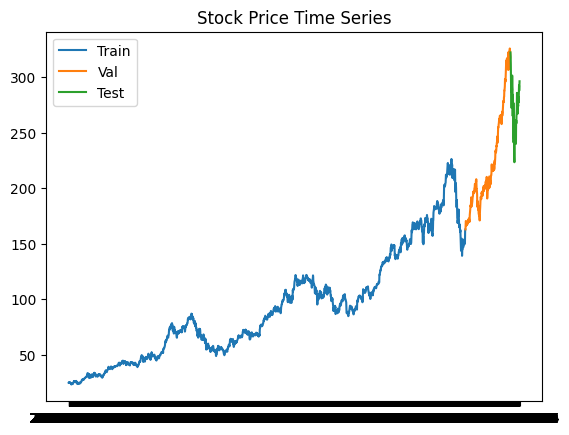

LR Coefficients: 
 [ 2.85816360e-05  2.20401159e-07 -5.74687115e-05  3.00000867e+00
  2.69774499e-06 -6.66672330e-01 -4.44442481e-01 -2.96297798e-01
 -1.97525201e-01 -1.31687027e-01 -8.77851897e-02 -5.85308581e-02
 -3.90160233e-02 -2.60162020e-02 -1.73425018e-02 -1.15605091e-02
 -7.70689894e-03 -5.13779011e-03 -3.42512795e-03 -2.28036865e-03
 -1.52186789e-03 -1.01742186e-03 -6.70268282e-04 -4.50761377e-04
 -2.99205264e-04 -1.98742084e-04 -1.34835396e-04 -9.01069907e-05
 -5.56389733e-05 -9.01447675e-05 -1.36372125e-05  1.57061551e-07
  8.77064835e-08  7.31814756e-06 -1.08300024e-06  1.02967368e-07
  1.25910779e-05 -7.60837914e-07  9.23259696e-09 -4.20586781e-06
  1.32013334e-06 -1.34887351e-07 -9.68267988e-06  1.74309931e-06
 -1.89879087e-07 -5.57248784e-06 -2.57711736e-07  3.16939769e-08
  1.34717985e-05 -5.63168804e-07  2.05360890e-08  4.00923407e-06
 -1.17176840e-06  1.09339537e-07 -5.67356512e-07  8.78935830e-07
 -8.29030630e-08 -2.30924109e-06 -2.37702875e-07  3.92339050e-08
  5.14

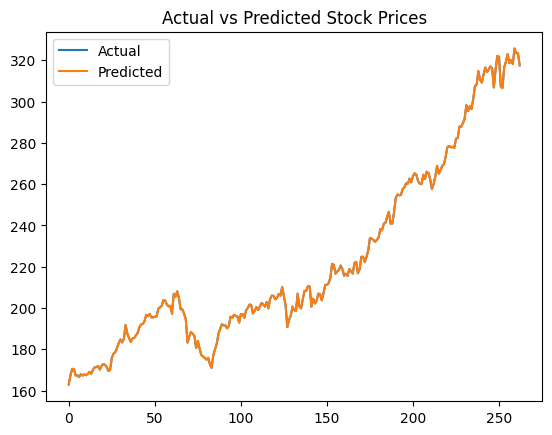

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2636
Training Set length -  2319
Validation Set length -  263
Test Set length -  52
(2319, 70) (263, 70) (54, 70)
(2319,) (263,) (54,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -                      Date  Actual  Predicted
0    2019-02-01 00:00:00  162.93   162.8715
1    2019-02-04 00:00:00  167.56   163.9731
2    2019-02-05 00:00:00  170.43   167.1421
3    2019-02-06 00:00:00  170.48   171.3263
4    2019-02-07 00:00:00  167.26   170.7173
..                   ...     ...        ...
258  2020-02-11 00:00:00  318.17   222.3204
259  2020-02-12 00:00:00  325.73   222.7948
260  2020-02-13 00:00:00  323.41   222.8209
261  2020-02-14 00:00:00  323.49   223.2073
262  2020-02-18 00:00:00  317.57   221.8626

[263 rows x 3 columns]
Plotting Actual vs Predicted for -  Random For

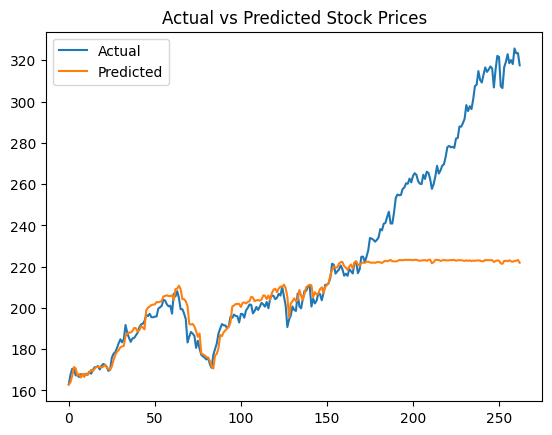

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2636
Training Set length -  2319
Validation Set length -  263
Test Set length -  52
(2319, 70) (263, 70) (54, 70)
(2319,) (263,) (54,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


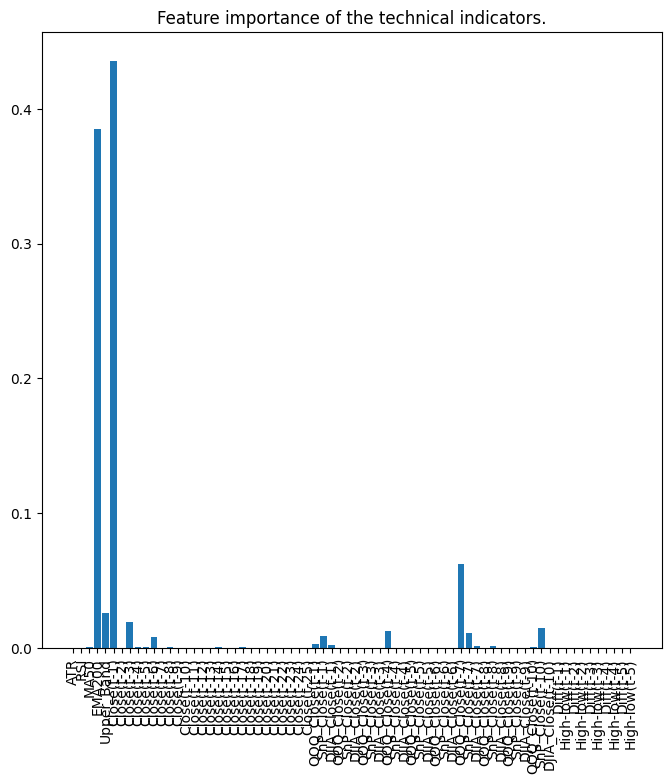

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -                      Date  Actual   Predicted
0    2019-02-01 00:00:00  162.93  165.462311
1    2019-02-04 00:00:00  167.56  167.553848
2    2019-02-05 00:00:00  170.43  170.155914
3    2019-02-06 00:00:00  170.48  172.793915
4    2019-02-07 00:00:00  167.26  171.094757
..                   ...     ...         ...
258  2020-02-11 00:00:00  318.17  217.757874
259  2020-02-12 00:00:00  325.73  217.466461
260  2020-02-13 00:00:00  323.41  218.004395
261  2020-02-14 00:00:00  323.49  218.423340
262  2020-02-18 00:00:00  317.57  217.968399

[263 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


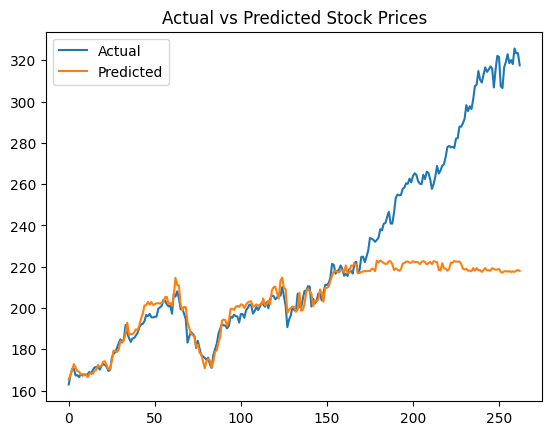

Saving Metrics in Json for Stock -  AAPL
z=None
Initiating Pipeline for Stock Ticker ----  GE
Loading Historical Price data for GE....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
     

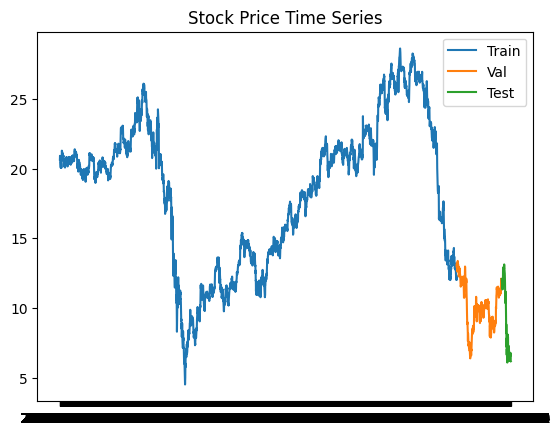

LR Coefficients: 
 [ 1.88059326e-05 -2.35758782e-08 -5.55436699e-05  3.00000799e+00
 -4.67040237e-07 -6.66664480e-01 -4.44444556e-01 -2.96301824e-01
 -1.97528744e-01 -1.31687372e-01 -8.77888840e-02 -5.85261100e-02
 -3.90230970e-02 -2.60080122e-02 -1.73390569e-02 -1.15617499e-02
 -7.70448985e-03 -5.13484126e-03 -3.42649868e-03 -2.28106246e-03
 -1.52526851e-03 -1.01371297e-03 -6.74378396e-04 -4.49044567e-04
 -3.01376782e-04 -1.97817525e-04 -1.32644572e-04 -8.95962947e-05
 -5.79095659e-05 -8.98580605e-05  7.02500355e-07  8.20722652e-08
 -1.59342477e-08  3.00329151e-07 -1.22273179e-07  1.04764695e-08
 -2.16203077e-06  1.21691254e-07  4.34439029e-09  8.25919726e-07
 -2.24530285e-08 -4.51762899e-09 -1.53147191e-06  6.13114758e-08
  3.31324923e-09  2.55793768e-07  6.26200388e-08 -1.05644283e-08
  3.46841459e-07 -8.99407726e-08  3.63877295e-09 -7.95827468e-07
  1.11282954e-07  5.03463404e-09  7.15763318e-08  3.77692227e-08
 -4.57737903e-09  1.89581368e-06 -2.32256517e-07  8.84073859e-09
 -1.66

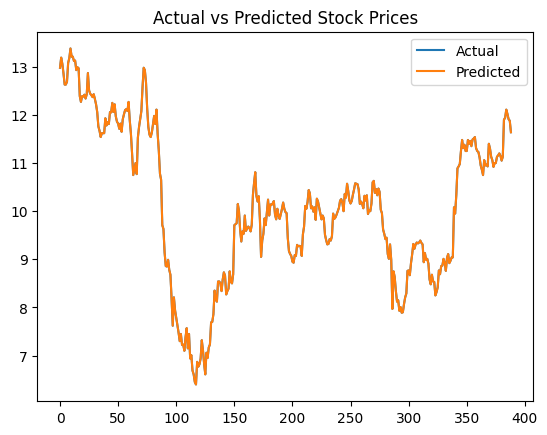

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  3892
Training Set length -  3424
Validation Set length -  389
Test Set length -  77
(3424, 70) (389, 70) (79, 70)
(3424,) (389,) (79,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -                      Date  Actual  Predicted
0    2018-06-26 00:00:00   12.98    12.3446
1    2018-06-27 00:00:00   13.19    12.8823
2    2018-06-28 00:00:00   13.06    13.0723
3    2018-06-29 00:00:00   12.86    13.0723
4    2018-07-02 00:00:00   12.63    12.9033
..                   ...     ...        ...
384  2020-01-06 00:00:00   12.11    11.9479
385  2020-01-07 00:00:00   12.02    12.0129
386  2020-01-08 00:00:00   11.91    12.0196
387  2020-01-09 00:00:00   11.88    11.9823
388  2020-01-10 00:00:00   11.64    11.8447

[389 rows x 3 columns]
Plotting Actual vs Predicted for -  Random For

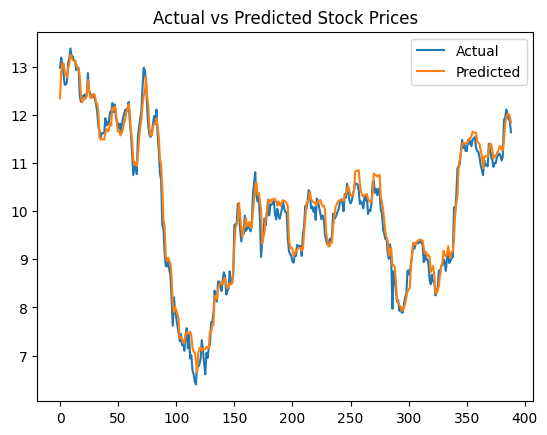

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  3892
Training Set length -  3424
Validation Set length -  389
Test Set length -  77
(3424, 70) (389, 70) (79, 70)
(3424,) (389,) (79,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


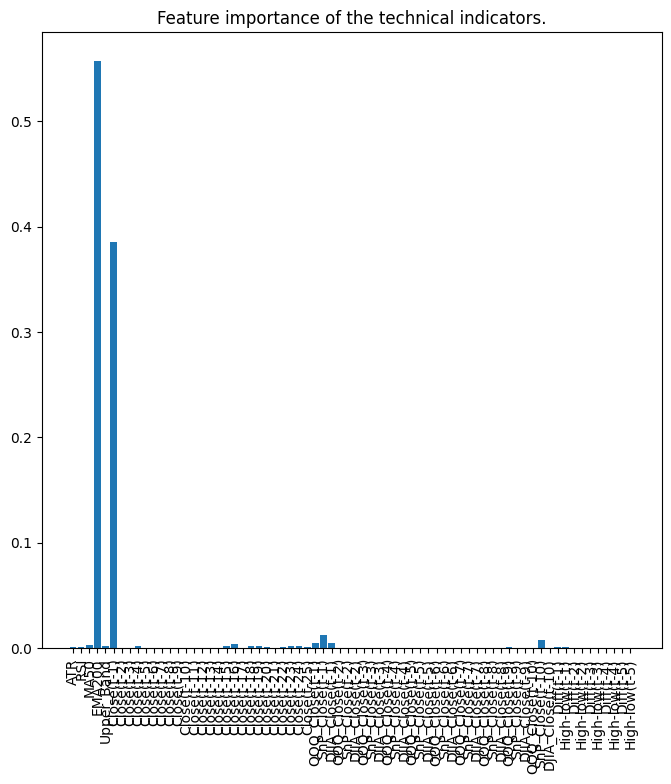

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -                      Date  Actual  Predicted
0    2018-06-26 00:00:00   12.98  12.366381
1    2018-06-27 00:00:00   13.19  12.751494
2    2018-06-28 00:00:00   13.06  13.011589
3    2018-06-29 00:00:00   12.86  12.939150
4    2018-07-02 00:00:00   12.63  12.635699
..                   ...     ...        ...
384  2020-01-06 00:00:00   12.11  11.990605
385  2020-01-07 00:00:00   12.02  12.038791
386  2020-01-08 00:00:00   11.91  12.038791
387  2020-01-09 00:00:00   11.88  12.058482
388  2020-01-10 00:00:00   11.64  11.950523

[389 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


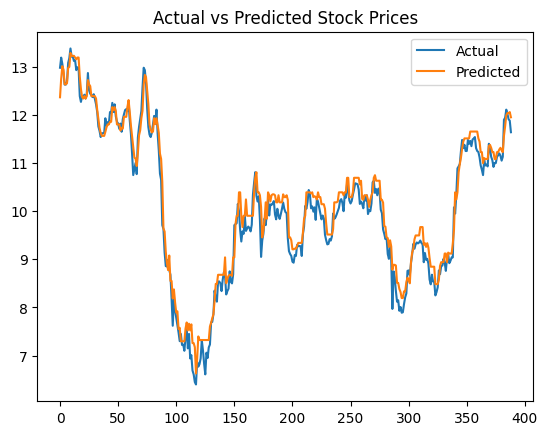

Saving Metrics in Json for Stock -  GE
z=None
Initiating Pipeline for Stock Ticker ----  JPM
Loading Historical Price data for JPM....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
     

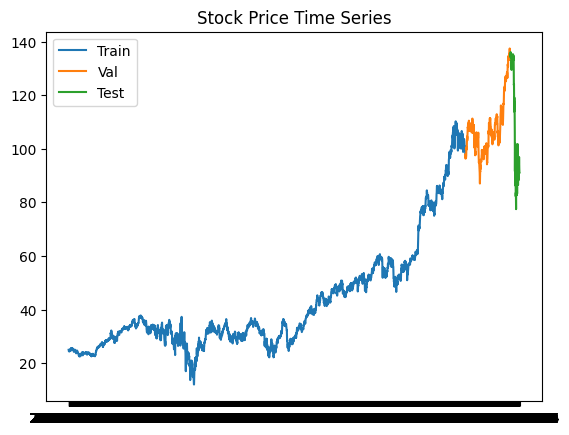

LR Coefficients: 
 [ 1.92602866e-05  2.66696552e-07 -6.00582890e-05  2.99999785e+00
  6.51772662e-07 -6.66661170e-01 -4.44444154e-01 -2.96296183e-01
 -1.97531059e-01 -1.31682749e-01 -8.77937489e-02 -5.85254938e-02
 -3.90180442e-02 -2.60116200e-02 -1.73394081e-02 -1.15616653e-02
 -7.70604724e-03 -5.13673921e-03 -3.42417490e-03 -2.28093896e-03
 -1.52130196e-03 -1.01287894e-03 -6.74793312e-04 -4.50901061e-04
 -3.01598604e-04 -1.99537391e-04 -1.30698457e-04 -8.88153614e-05
 -6.06482955e-05 -8.48064966e-05  1.22948999e-06  3.33115556e-08
 -1.99701831e-08  9.90266259e-07 -2.11796843e-07  3.03677994e-08
 -1.98494408e-06 -3.00029479e-07  5.47662758e-08  2.82223155e-06
 -3.00977645e-08 -2.08557536e-08  3.14722434e-07  1.41753360e-07
 -3.31202151e-08  1.40745256e-06  1.16522595e-07 -4.84996875e-09
 -1.48696403e-06 -5.67018184e-08  3.04808845e-10 -4.08950626e-06
  4.85777514e-07 -1.58709668e-08 -6.69672703e-08  1.35206951e-07
 -1.45513981e-09  9.82829770e-07 -3.03686052e-07  1.07951813e-08
 -1.31

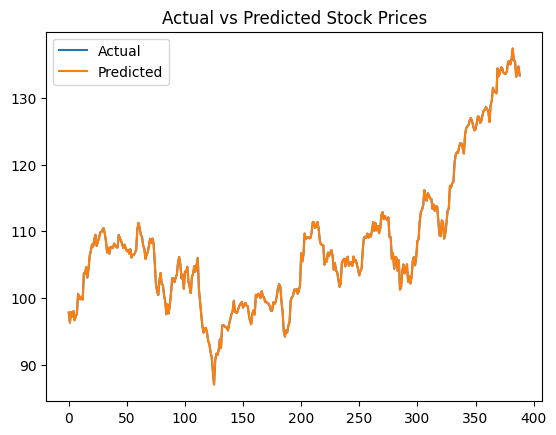

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  3892
Training Set length -  3424
Validation Set length -  389
Test Set length -  77
(3424, 70) (389, 70) (79, 70)
(3424,) (389,) (79,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -                      Date  Actual  Predicted
0    2018-06-26 00:00:00   97.81    98.3759
1    2018-06-27 00:00:00   96.30    98.4692
2    2018-06-28 00:00:00   97.88    98.1447
3    2018-06-29 00:00:00   97.20    98.4213
4    2018-07-02 00:00:00   98.02    98.3109
..                   ...     ...        ...
384  2020-01-06 00:00:00  135.49   108.0768
385  2020-01-07 00:00:00  133.18   107.9089
386  2020-01-08 00:00:00  134.22   107.8913
387  2020-01-09 00:00:00  134.71   107.9890
388  2020-01-10 00:00:00  133.37   107.8152

[389 rows x 3 columns]
Plotting Actual vs Predicted for -  Random For

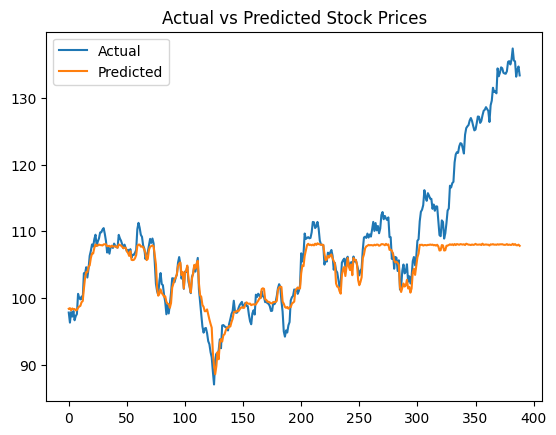

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  3892
Training Set length -  3424
Validation Set length -  389
Test Set length -  77
(3424, 70) (389, 70) (79, 70)
(3424,) (389,) (79,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


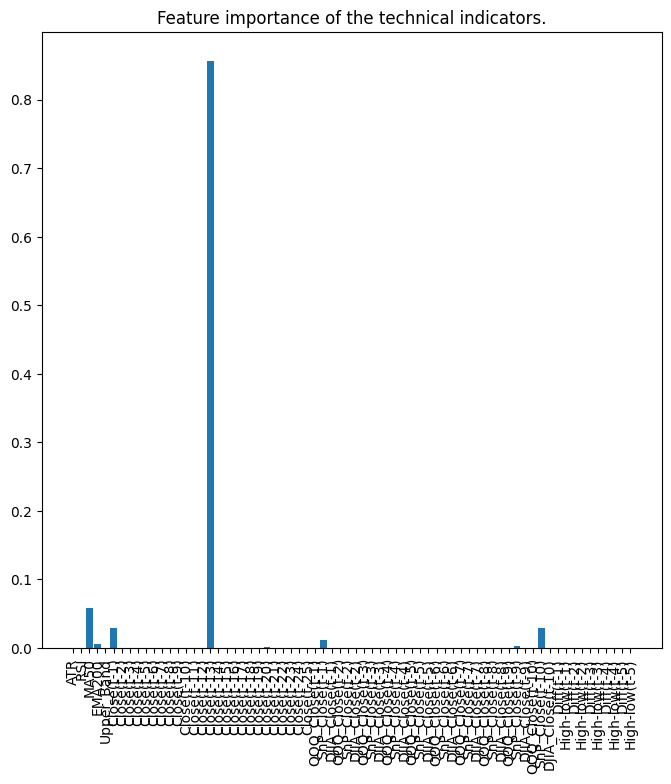

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -                      Date  Actual   Predicted
0    2018-06-26 00:00:00   97.81   96.262550
1    2018-06-27 00:00:00   96.30   96.187912
2    2018-06-28 00:00:00   97.88   97.404976
3    2018-06-29 00:00:00   97.20   97.392967
4    2018-07-02 00:00:00   98.02   97.370514
..                   ...     ...         ...
384  2020-01-06 00:00:00  135.49  107.813194
385  2020-01-07 00:00:00  133.18  107.177132
386  2020-01-08 00:00:00  134.22  107.157814
387  2020-01-09 00:00:00  134.71  107.402969
388  2020-01-10 00:00:00  133.37  106.979439

[389 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


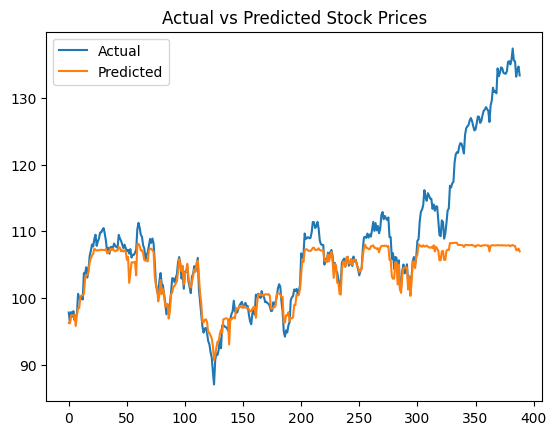

Saving Metrics in Json for Stock -  JPM
z=None
Initiating Pipeline for Stock Ticker ----  MSFT
Loading Historical Price data for MSFT....
Index(['Close', 'Diff', 'High-low', 'QQQ_Close', 'SnP_Close', 'DJIA_Close',
       'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band'],
      dtype='object')
Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  26
Index(['Close', 'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_Band', 'Close(t-1)',
       'Close(t-2)', 'Close(t-3)', 'Close(t-4)', 'Close(t-5)', 'Close(t-6)',
       'Close(t-7)', 'Close(t-8)', 'Close(t-9)', 'Close(t-10)', 'Close(t-11)',
       'Close(t-12)', 'Close(t-13)', 'Close(t-14)', 'Close(t-15)',
       'Close(t-16)', 'Close(t-17)', 'Close(t-18)', 'Close(t-19)',
       'Close(t-20)', 'Close(t-21)', 'Close(t-22)', 'Close(t-23)',
       'Close(t-24)', 'Close(t-25)', 'QQQ_Close(t-1)', 'SnP_Close(t-1)',
       'DJIA_Close(t-1)', 'QQQ_Close(t-2)', 'SnP_Close(t-2)',
       'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
  

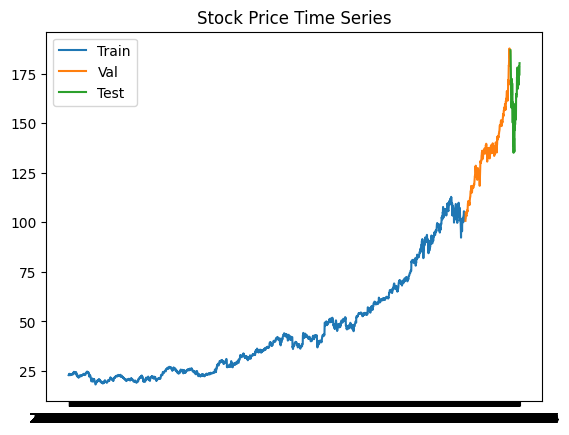

LR Coefficients: 
 [ 1.31571662e-05  6.60877713e-07 -6.56104155e-05  2.99999000e+00
  1.13041758e-06 -6.66668467e-01 -4.44437383e-01 -2.96296738e-01
 -1.97530357e-01 -1.31682408e-01 -8.77937282e-02 -5.85257248e-02
 -3.90153395e-02 -2.60025143e-02 -1.73423005e-02 -1.15618376e-02
 -7.70459332e-03 -5.13716513e-03 -3.42241801e-03 -2.28183432e-03
 -1.52235545e-03 -1.01795050e-03 -6.72735135e-04 -4.49805080e-04
 -3.01314192e-04 -1.98689936e-04 -1.28604348e-04 -8.96089103e-05
 -6.09180560e-05 -8.15802219e-05  2.15568149e-06 -1.07893260e-07
  2.66936218e-09  1.34685607e-06 -4.50962364e-07  4.08394351e-08
  1.34980523e-06 -1.03202752e-07  7.62253594e-10 -4.36734952e-07
  5.46288504e-07 -4.20045588e-08 -5.13470100e-06  5.61478598e-07
 -5.16696856e-08  6.20530736e-06 -3.25809894e-07  1.44270005e-08
  2.42288577e-06 -2.58967166e-07  2.13358490e-08 -1.71885882e-07
 -3.99848222e-07  6.14702091e-08 -1.13786273e-05  5.47900943e-07
 -2.05191224e-08  4.26147334e-06 -2.23298561e-08 -2.90165727e-08
  1.81

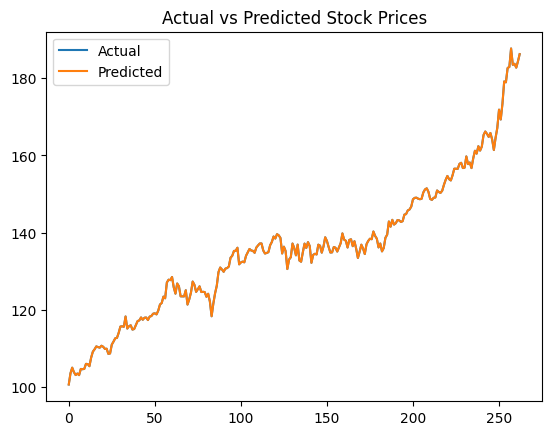

 
Training Random Forest Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2636
Training Set length -  2319
Validation Set length -  263
Test Set length -  52
(2319, 70) (263, 70) (54, 70)
(2319,) (263,) (54,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....
 
Predicted vs Actual for  Random Forest
Stock Prediction on Test Data -                      Date  Actual  Predicted
0    2019-02-01 00:00:00  100.73   102.0374
1    2019-02-04 00:00:00  103.63   103.1672
2    2019-02-05 00:00:00  105.08   104.0357
3    2019-02-06 00:00:00  103.91   103.9091
4    2019-02-07 00:00:00  103.17   103.8874
..                   ...     ...        ...
258  2020-02-11 00:00:00  183.43   111.7726
259  2020-02-12 00:00:00  183.70   111.7325
260  2020-02-13 00:00:00  182.70   111.7186
261  2020-02-14 00:00:00  184.33   111.7603
262  2020-02-18 00:00:00  186.20   111.7724

[263 rows x 3 columns]
Plotting Actual vs Predicted for -  Random For

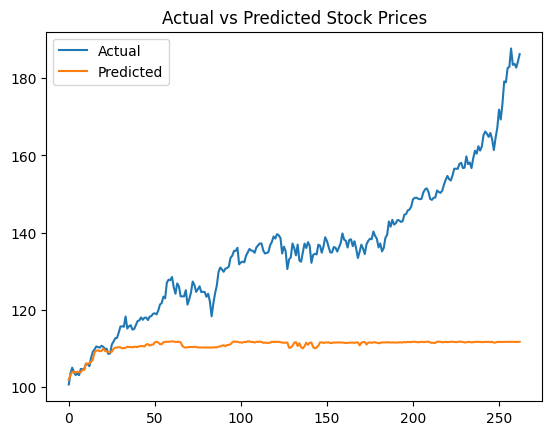

 
Training XGBoost Model
Splitting the data into Train and Test ...
 
Historical Stock Data length is -  2636
Training Set length -  2319
Validation Set length -  263
Test Set length -  52
(2319, 70) (263, 70) (54, 70)
(2319,) (263,) (54,)
Evaluating Metrics - MAE, MAPE, RMSE, R Square
 
Updating the metrics tracker....


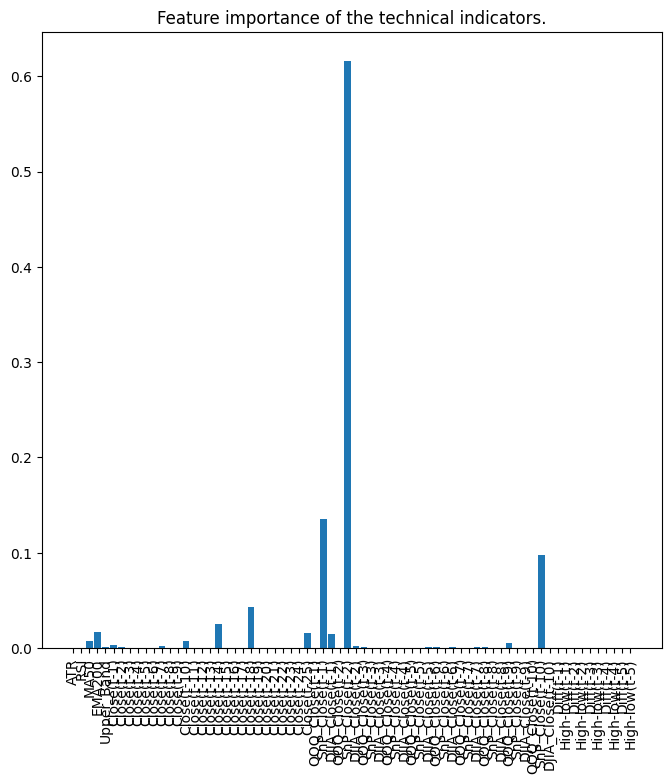

 
Predicted vs Actual for  XGBoost
Stock Prediction on Test Data -                      Date  Actual   Predicted
0    2019-02-01 00:00:00  100.73  102.185158
1    2019-02-04 00:00:00  103.63  103.227234
2    2019-02-05 00:00:00  105.08  104.304497
3    2019-02-06 00:00:00  103.91  103.427734
4    2019-02-07 00:00:00  103.17  103.566643
..                   ...     ...         ...
258  2020-02-11 00:00:00  183.43  111.685455
259  2020-02-12 00:00:00  183.70  111.622292
260  2020-02-13 00:00:00  182.70  111.509781
261  2020-02-14 00:00:00  184.33  111.633560
262  2020-02-18 00:00:00  186.20  111.685455

[263 rows x 3 columns]
Plotting Actual vs Predicted for -  XGBoost


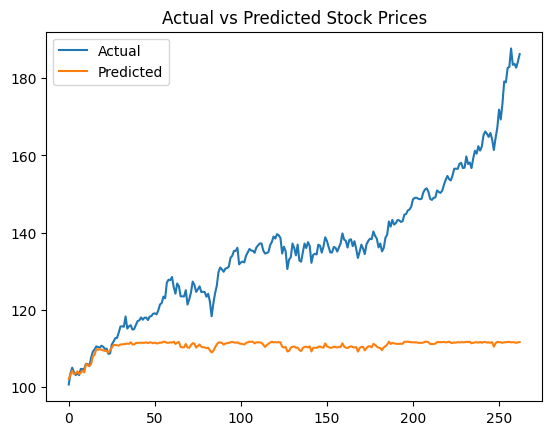

Saving Metrics in Json for Stock -  MSFT
z=None


In [7]:
Stocks = ['AAPL', 'GE', 'JPM', 'MSFT']
models = ['Linear Regression', 'Random Forest', 'XGBoost']
training = Stock_Prediction_Modeling(Stocks, models)
training.pipeline_sequence()

In [ ]:
import json

with open('metrics.txt') as f:
    eval_metrics = json.load(f)
    
eval_metrics

{'NKE': {'Linear Regression': {'Train_MAE': 0.0,
   'Train_RSq': 1.0,
   'Train_MAPE': 0.0,
   'Train_RMSE': 0.0,
   'Test_MAE': 0.0,
   'Test_RSq': 1.0,
   'Test_MAPE': 0.0,
   'Test_RMSE': 0.0},
  'Random Forest': {'Train_MAE': 0.22,
   'Train_RSq': 1.0,
   'Train_MAPE': 0.3,
   'Train_RMSE': 0.57,
   'Test_MAE': 0.68,
   'Test_RSq': 0.97,
   'Test_MAPE': 0.85,
   'Test_RMSE': 0.93},
  'XGBoost': {'Train_MAE': 0.29,
   'Train_RSq': 1.0,
   'Train_MAPE': 0.4,
   'Train_RMSE': 0.36,
   'Test_MAE': 0.67,
   'Test_RSq': 0.97,
   'Test_MAPE': 0.84,
   'Test_RMSE': 0.93},
  'LSTM': {'Train_MAE': 16.56,
   'Train_RSq': -0.08,
   'Train_MAPE': 21.4,
   'Train_RMSE': 20.75,
   'Test_MAE': 15.18,
   'Test_RSq': -4.85,
   'Test_MAPE': 17.5,
   'Test_RMSE': 16.69}},
 'IBM': {'Linear Regression': {'Train_MAE': 0.0,
   'Train_RSq': 1.0,
   'Train_MAPE': 0.0,
   'Train_RMSE': 0.0,
   'Test_MAE': 0.0,
   'Test_RSq': 1.0,
   'Test_MAPE': 0.0,
   'Test_RMSE': 0.0},
  'Random Forest': {'Train_MAE': 0.3

In [ ]:
Metrics = pd.DataFrame.from_dict({(i,j): eval_metrics[i][j] 
                           for i in eval_metrics.keys() 
                           for j in eval_metrics[i].keys()},
                       orient='index')
Metrics

Train_MAE  Train_RSq  Train_MAPE  Train_RMSE  \
NKE  Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.22       1.00        0.30        0.57   
     XGBoost                 0.29       1.00        0.40        0.36   
     LSTM                   16.56      -0.08       21.40       20.75   
IBM  Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.32       1.00        0.21        0.48   
     XGBoost                 0.31       1.00        0.20        0.40   
     LSTM                   24.06       0.00       16.77       29.73   
KO   Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.09       1.00        0.19        0.30   
     XGBoost                 0.21       1.00        0.45        0.28   
     LSTM                    7.75      -0.11       13.87       11.38   
GS   Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.49       1.00        0.32        0.69   
     XGBoost                 0.32       1.00        0.21        0.41   
     LSTM                   46.42      -0.54       35.62       54.62   
JNJ  Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.15       1.00        0.17        0.24   
     XGBoost                 0.26       1.00        0.31        0.34   
     LSTM                   29.13      -0.72       42.05       34.40   
NVDA Linear Regression       0.00       1.00        0.00        0.00   
     Random Forest           0.25       1.00        0.48        0.61   
     XGBoost                 0.20       1.00        0.88        0.28   
     LSTM                   78.87      -0.59      449.12       81.48   

                        Test_MAE  Test_RSq  Test_MAPE  Test_RMSE  
NKE  Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          0.68      0.97       0.85       0.93  
     XGBoost                0.67      0.97       0.84       0.93  
     LSTM                  15.18     -4.85      17.50      16.69  
IBM  Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          1.22      0.97       0.94       1.75  
     XGBoost                1.44      0.96       1.09       1.90  
     LSTM                  22.87     -6.14      17.35      24.63  
KO   Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          0.33      0.98       0.66       0.46  
     XGBoost                0.36      0.97       0.72       0.50  
     LSTM                   5.18     -2.38      10.00       6.18  
GS   Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          2.33      0.96       1.17       3.08  
     XGBoost                2.80      0.94       1.42       3.86  
     LSTM                  14.98     -0.06       7.49      17.98  
JNJ  Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest          1.24      0.90       0.91       1.71  
     XGBoost                0.93      0.94       0.69       1.27  
     LSTM                  15.22     -8.05      11.07      16.10  
NVDA Linear Regression      0.00      1.00       0.00       0.00  
     Random Forest         16.75      0.72      10.68      20.00  
     XGBoost               14.05      0.81       8.89      16.33  
     LSTM                  53.32     -1.58      25.14      66.59

In [ ]:
Metrics.to_csv('Evaluation.csv')

### Conclusion

Random Forest, XG Boost and Linear regression seems to work very well on such a long data as well. We have taken around 12-15 years of historical data which was divided into Training, Validation and Testing. 

These algorithms are able to catch the trend and move close to the Actual closing price in the right direction with a very low Mean Absolute error(MAE). The Evaluation Metrics is above to see how each algorithm performed on each stock. They worked so well because of the Feature Extraction we did to extract around 60 features including lagged Index funds prices, Technical Indicators like Exponential Moving Average, RSI, ADR, Willam's R, bollinger bands and many more. 

LSTMs did not perform well on this as expected, as the data is not using any sequence of previous many time steps. and LSTM will work better on time series data once we provide it with previous 30-60 days of lookback data for every prediction. 
Thats what we will be doing in the next Notebooks and then we will move to Portfolio Optimization. 